## Drifters and NOAA data Notebook

### Introduction
This notebook aims to interpolate the wind field from NOAA onto the drifter positions and calculate the surface Ekman current, and then add it to the geostrophic current.

### Data Sources
- Drifter Data:
  - Source: NOAA
  - Collection Frequency: Every 6 hours
  - Total Number of Drifters: 221

- NOAA Data:
  - Source: National Oceanic and Atmospheric Administration 
  - Collection Frequency: Every Day
  - Data Product: CoastWatch Caribb-NOAA AOML

### Tasks

#### 1. Interpolation and Ekman current

- Interpolating the wind field from NOAA onto the drifter positions and calculating the surface Ekman current.

#### 2. Adding the surface Ekman current to the geostrophic current.
-  Adding the surface Ekman current to the geostrophic current (NOAA current) and conclusion.


#### 1. Interpolation and Ekman current

## Import Library

In [2]:
import pandas as pd
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
from scipy.interpolate import interp2d

import cartopy.crs as ccrs
import cartopy.mpl.ticker as cticker
import cartopy.feature as cfeature
from cartopy import config
import matplotlib.animation
from scipy.stats import linregress

## Read Drifter Data

In [129]:
fn='./drifter_6hour_qc_893c_d15d_c4b7_U1711967648742.nc';
ds=xr.open_dataset(fn);

## Extract Coordinates and Variables

In [130]:
ve_curr = ds.ve.values
vn_curr = ds.vn.values
sst = ds.sst.values
lon = ds.longitude.values
lat = ds.latitude.values
time = ds.time.values

## Creation of Pandas Array for Drifter Data

In [131]:
data = {
    'longitude': lon,
    'latitude' : lat,
    'time'     : time,
    've'       : ve_curr,
    'vn'       : vn_curr,
    'sst'      : sst
}

df = pd.DataFrame(data)
df

,longitude,latitude,time,ve,vn,sst
0,-14.478,-18.548,2023-01-01 00:00:00,-0.13760,-0.07635,23.612
1,-14.499,-18.556,2023-01-01 06:00:00,-0.09969,0.01322,23.564
2,-14.519,-18.543,2023-01-01 12:00:00,-0.15719,0.08193,23.699
3,-14.563,-18.524,2023-01-01 18:00:00,-0.26155,0.03533,23.856
4,-14.626,-18.529,2023-01-02 00:00:00,-0.23922,-0.07837,23.717
...,...,...,...,...,...,...
78378,-22.006,-19.946,2023-06-11 12:00:00,-0.03853,-0.05076,25.189
78379,-22.013,-19.961,2023-06-11 18:00:00,-0.05150,-0.06262,25.179
78380,-22.027,-19.971,2023-06-12 00:00:00,-0.06030,-0.04773,25.133
78381,-22.038,-19.980,2023-06-12 06:00:00,-0.06036,-0.05688,25.093


## Selecting Drifter Data

In [132]:
# Test: Our selected drifter has 1102 observations. However, we will limit it to 500 observations because the coordinates 
# of our CMEMS data are 158 in dimension, and the linear interpolation method we use requires it in this situation.

df_1 = df[0:500]
df_1

,longitude,latitude,time,ve,vn,sst
0,-14.478,-18.548,2023-01-01 00:00:00,-0.13760,-0.07635,23.612
1,-14.499,-18.556,2023-01-01 06:00:00,-0.09969,0.01322,23.564
2,-14.519,-18.543,2023-01-01 12:00:00,-0.15719,0.08193,23.699
3,-14.563,-18.524,2023-01-01 18:00:00,-0.26155,0.03533,23.856
4,-14.626,-18.529,2023-01-02 00:00:00,-0.23922,-0.07837,23.717
...,...,...,...,...,...,...
495,-22.450,-17.101,2023-05-04 18:00:00,0.02080,0.00505,26.874
496,-22.443,-17.101,2023-05-05 00:00:00,0.03049,0.02243,26.792
497,-22.437,-17.092,2023-05-05 06:00:00,0.02100,0.03648,26.749
498,-22.435,-17.087,2023-05-05 12:00:00,-0.00296,0.03702,26.820


## Now let's interpolate the NOAA data onto the grid of the drifter data.

### Case of Geostrophic Velocity u_current and  v_current

In [133]:
# Chargement des données des bouées dérivantes à partir du DataFrame
df_bouees = df[0:500]   
# Supposez que votre DataFrame contient des colonnes 'temps', 'latitude' et 'longitude' 

# Chargement des données satellitaires à partir du fichier netCDF
ds_satellitaires = xr.open_dataset('miamicurrents_f30e_6501_f060.nc')   
# Supposez que vos données satellitaires sont stockées dans une variable appelée 'u_current' et 'v_current'

# Extraction des données de courant satellitaires pour les mêmes positions spatiales et temporelles que les bouées
latitudes = df_bouees['latitude']
longitudes = df_bouees['longitude']
temps = df_bouees['time']

satellitaires_courant_u = []
for i in range(len(df_bouees)):
    lat = latitudes[i]
    lon = longitudes[i]
    time = temps[i]
    courant = ds_satellitaires['u_current'].interp(latitude=lat, longitude=lon, time=time).values
    satellitaires_courant_u.append(courant)

satellitaires_courant_v = []
for i in range(len(df_bouees)):
    lat = latitudes[i]
    lon = longitudes[i]
    time = temps[i]
    courant = ds_satellitaires['v_current'].interp(latitude=lat, longitude=lon, time=time).values
    satellitaires_courant_v.append(courant)

### Case of east-West and North-South Component of 10m Surface Wind(u_mean) and (v_mean)

In [134]:
# Chargement des données des bouées dérivantes à partir du DataFrame
df_bouees = df[0:500]   
# Supposez que votre DataFrame contient des colonnes 'temps', 'latitude' et 'longitude' 

# Chargement des données satellitaires à partir du fichier netCDF
ds_satellitaires = xr.open_dataset('erdlasFnWind10_LonPM180_f502_71d8_5228.nc')   
# Supposez que vos données satellitaires de vent sont stockées dans une variable appelée 'u_mean' et 'v_mean'

# Extraction des données de vent satellitaires pour les mêmes positions spatiales et temporelles que les bouées
latitudes = df_bouees['latitude']
longitudes = df_bouees['longitude']
temps = df_bouees['time']

satellitaires_vent_u = []
for i in range(len(df_bouees)):
    lat = latitudes[i]
    lon = longitudes[i]
    time = temps[i]
    courant = ds_satellitaires['u_mean'].interp(latitude=lat, longitude=lon, time=time).values
    satellitaires_vent_u.append(courant)

satellitaires_vent_v = []
for i in range(len(df_bouees)):
    lat = latitudes[i]
    lon = longitudes[i]
    time = temps[i]
    courant = ds_satellitaires['v_mean'].interp(latitude=lat, longitude=lon, time=time).values
    satellitaires_vent_v.append(courant)

### Case of East-West and North-South Component of 10m Wind Stress (taux_mean and tauy_mean) plus magnitude uv_mag_mean

In [135]:
# Chargement des données des bouées dérivantes à partir du DataFrame
df_bouees = df[0:500]   
# Supposez que votre DataFrame contient des colonnes 'temps', 'latitude' et 'longitude' 

# Chargement des données satellitaires à partir du fichier netCDF
ds_satellitaires = xr.open_dataset('erdlasFnWind20_LonPM180_f502_71d8_5228.nc')   
# Supposez que vos données satellitaires de stress du vent sont stockées dans une variable appelée 'taux_mean' et ''tauy_mean'

# Extraction des données de stress de vent satellitaires pour les mêmes positions spatiales et temporelles que les bouées
latitudes = df_bouees['latitude']
longitudes = df_bouees['longitude']
temps = df_bouees['time']

satellitaires_taux = []
for i in range(len(df_bouees)):
    lat = latitudes[i]
    lon = longitudes[i]
    time = temps[i]
    courant = ds_satellitaires['taux_mean'].interp(latitude=lat, longitude=lon, time=time).values
    satellitaires_taux.append(courant)

satellitaires_tauy = []
for i in range(len(df_bouees)):
    lat = latitudes[i]
    lon = longitudes[i]
    time = temps[i]
    courant = ds_satellitaires['tauy_mean'].interp(latitude=lat, longitude=lon, time=time).values
    satellitaires_tauy.append(courant)

satellitaires_uv_mag = []
for i in range(len(df_bouees)):
    lat = latitudes[i]
    lon = longitudes[i]
    time = temps[i]
    courant = ds_satellitaires['uv_mag_mean'].interp(latitude=lat, longitude=lon, time=time).values
    satellitaires_uv_mag.append(courant)

## Calculation of surface Ekman current

## Calculation of Ekman current:

The speed of Ekman current can be calculated using the Ekman equation:
$$
V_{Ek} = \frac{{1}}{{\rho fH}} \cdot \nabla \times \tau 
$$
Where:
- $ V_{Ek}$ is the Ekman current.
- $ \tau $ is the wind stress, which is the force exerted by the wind on the water surface.
- $ \rho $ is the water density.
- $ f $ is the Coriolis parameter, which depends on latitude.

The formula for wind stress can be expressed as follows:

$$ \tau = \rho_a \cdot C_d \cdot \| \text{V} \| \cdot \text{V} $$

where :

- $\rho_a$ is the air density (in $ \text{kg/m}^3 $),
- $ C_d $ is the drag coefficient (dimensionless),
- $\| \text{V} \|$ is the magnitude of the wind velocity vector (in $ \text{m/s} $),
- $\text{V} $ is the wind velocity vector,
- $\tau$ is in $N/m^{2}$

In [136]:
# Calculate wind shear components tau_x and tau_y
H = 2  # Profondeur de la couche d'Ekman
rho = 1025   # Masse volumique de l'eau (kg/m^3)  

# Calculate the Coriolis parameter f based on latitudes
f = 2 * np.pi * 7.29e-5 * np.sin(np.deg2rad(latitudes))

# Calculate Ekman current components
u_e_sat =  satellitaires_tauy / (f * rho*H)
v_e_sat =  satellitaires_taux / (-f * rho*H)

# Display results
#print("Component x of Ekman current (u_e):", u_e_sat)
#print("Component y of Ekman current (v_e):", v_e_sat)

#### 2. Adding the surface Ekman current to the geostrophic current.
-  Adding the surface Ekman current to the geostrophic current (NOAA current) and conclusion.

## u_current plus Ekman zonal current

In [137]:
# u_total = u_geostro + u_e_sat
u_total = satellitaires_courant_u + u_e_sat

## v_current plus Ekman meridional current

In [138]:
# u_total = v_geostro + v_e_sat
v_total = satellitaires_courant_v + v_e_sat

## Creation of Pandas Array for NOAA total current Data

In [139]:
data = {
     
    'u_total'       : u_total,
    'v_total'       : v_total
     
}

dF = pd.DataFrame(data)
dF

,u_total,v_total
0,-0.252921,-0.203022
1,-0.251090,-0.204578
2,-0.259878,-0.209030
3,-0.268680,-0.215209
4,-0.259984,-0.221076
...,...,...
495,-0.023555,-0.128973
496,-0.017863,-0.131310
497,-0.025230,-0.143061
498,-0.031401,-0.153349


## Now Let's Compare Drifter Speeds and  NOAA Speeds

## Comparison between ve and u_total of NOAA

## Using Regression and Correlation

Corrélation de Pearson: 0.38545918286707403
Valeur de p (p-value): 3.700487485758552e-19


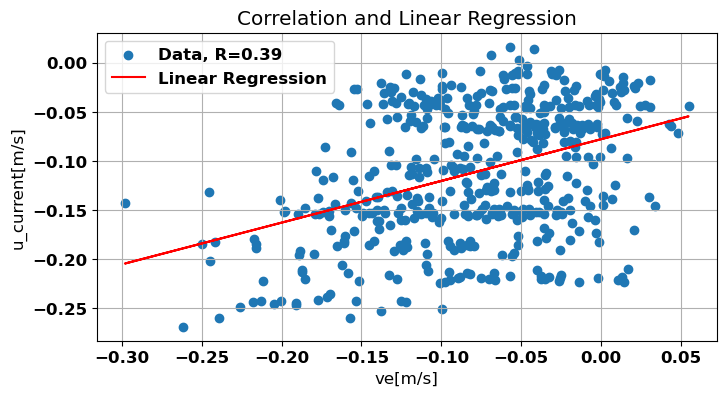

In [140]:
from scipy.stats import pearsonr

# According to the following, we can simply note that the correlation between "ve" and "ugosa_interpolate" is 0.34. 
# This means that there is a general tendency for the values of the variables to increase together, but this relationship is not very strong.
# Calcul de la corrélation spatiale et temporelle Pearson
bouees_courant_u = df_1['ve']
correlation, p_value = pearsonr(dF['u_total'],bouees_courant_u)

print("Corrélation de Pearson:", correlation)
print("Valeur de p (p-value):", p_value)

# Fit linear regression model

slope, intercept, _, _, _ = linregress( bouees_courant_u,dF['u_total'])

# Plot data and linear regression line
plt.figure(figsize=(8, 4))
plt.scatter(bouees_courant_u,dF['u_total'], label=f'Data, R={correlation:.2f}')
plt.plot(bouees_courant_u, slope*bouees_courant_u + intercept, color='red', label='Linear Regression')
plt.xlabel('ve[m/s]')
plt.ylabel('u_current[m/s]')
plt.legend()
plt.title('Correlation and Linear Regression')
plt.grid(True)

# Set font size and font weight for tick labels
plt.rcParams['font.size'] = 12
plt.rcParams['font.weight'] = 'bold'

# save graphe
# plt.savefig("fig11 mode.png")
# Show plot
plt.show()

## Using Time Series

### The use of Kalman filter for smoothing $v_e$ and $u_total$

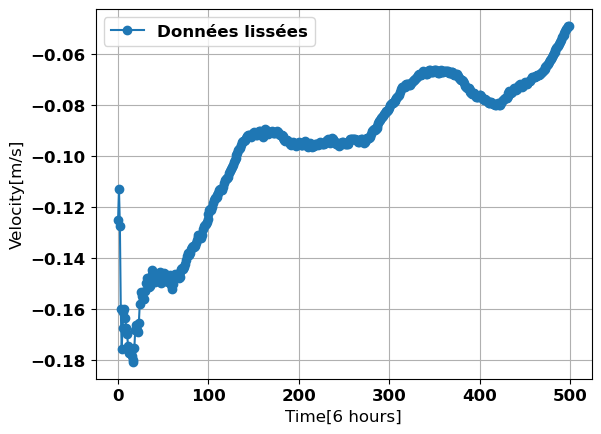

In [141]:
import numpy as np
import matplotlib.pyplot as plt

class KalmanFilter:
    def __init__(self, process_variance, measurement_variance, estimated_measurement_variance):
        self.process_variance = process_variance
        self.measurement_variance = measurement_variance
        self.estimated_measurement_variance = estimated_measurement_variance
        self.posteri_estimate = 0.0
        self.posteri_error_estimate = 1.0

    def update(self, measurement):
        # Prediction update
        priori_estimate = self.posteri_estimate
        priori_error_estimate = self.posteri_error_estimate + self.process_variance

        # Measurement update
        blending_factor = priori_error_estimate / (priori_error_estimate + self.estimated_measurement_variance)
        self.posteri_estimate = priori_estimate + blending_factor * (measurement - priori_estimate)
        self.posteri_error_estimate = (1 - blending_factor) * priori_error_estimate

    def get_latest_estimated_measurement(self):
        return self.posteri_estimate

# Charger la série temporelle
# Supposons que votre série temporelle est dans un array numpy appelé "serie_temporelle"
# Remplacez "serie_temporelle.npy" par le nom de votre fichier contenant la série temporelle
serie_temporelle = bouees_courant_u

# Paramètres du filtre de Kalman
process_variance = 1e-5
measurement_variance = 0.1
estimated_measurement_variance = 0.1

# Initialiser le filtre de Kalman
kf = KalmanFilter(process_variance, measurement_variance, estimated_measurement_variance)

# Lisser la série temporelle en utilisant le filtre de Kalman
filtered_values_1 = []
for measurement in serie_temporelle:
    kf.update(measurement)
    filtered_values_1.append(kf.get_latest_estimated_measurement())

# Afficher les données originales et lissées
#plt.plot(df_1['time'],serie_temporelle, marker='o', linestyle='-', label='Données originales')
plt.plot(filtered_values_1, marker='o', linestyle='-', label='Données lissées')
plt.xlabel('Time[6 hours]')
plt.ylabel('Velocity[m/s]')
plt.grid(True)
plt.legend()
plt.show()

## case of $u_total$

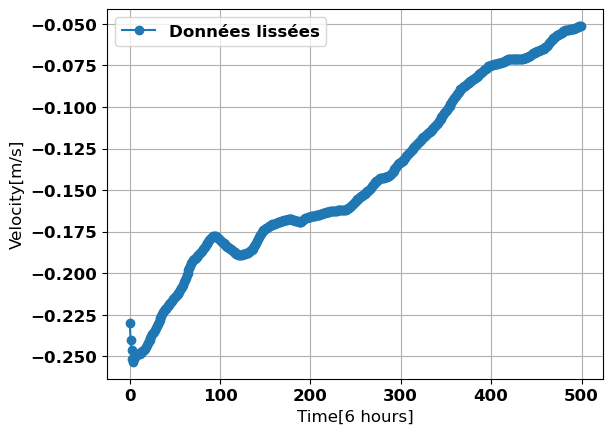

In [142]:
import numpy as np
import matplotlib.pyplot as plt

class KalmanFilter:
    def __init__(self, process_variance, measurement_variance, estimated_measurement_variance):
        self.process_variance = process_variance
        self.measurement_variance = measurement_variance
        self.estimated_measurement_variance = estimated_measurement_variance
        self.posteri_estimate = 0.0
        self.posteri_error_estimate = 1.0

    def update(self, measurement):
        # Prediction update
        priori_estimate = self.posteri_estimate
        priori_error_estimate = self.posteri_error_estimate + self.process_variance

        # Measurement update
        blending_factor = priori_error_estimate / (priori_error_estimate + self.estimated_measurement_variance)
        self.posteri_estimate = priori_estimate + blending_factor * (measurement - priori_estimate)
        self.posteri_error_estimate = (1 - blending_factor) * priori_error_estimate

    def get_latest_estimated_measurement(self):
        return self.posteri_estimate

# Charger la série temporelle
# Supposons que votre série temporelle est dans un array numpy appelé "serie_temporelle"
# Remplacez "serie_temporelle.npy" par le nom de votre fichier contenant la série temporelle
serie_temporelle = dF['u_total']

# Paramètres du filtre de Kalman
process_variance = 1e-5
measurement_variance = 0.1
estimated_measurement_variance = 0.1

# Initialiser le filtre de Kalman
kf = KalmanFilter(process_variance, measurement_variance, estimated_measurement_variance)

# Lisser la série temporelle en utilisant le filtre de Kalman
filtered_values_2 = []
for measurement in serie_temporelle:
    kf.update(measurement)
    filtered_values_2.append(kf.get_latest_estimated_measurement())

# Afficher les données originales et lissées
#plt.plot(df_1['time'],serie_temporelle, marker='o', linestyle='-', label='Données originales')
plt.plot(filtered_values_2, marker='o', linestyle='-', label='Données lissées')
plt.xlabel('Time[6 hours]')
plt.ylabel('Velocity[m/s]')
plt.grid(True)
plt.legend()
plt.show()

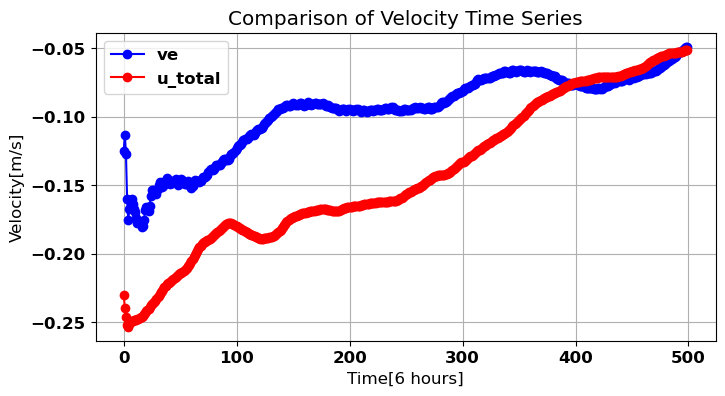

In [143]:
# Plot time series
plt.figure(figsize=(8, 4))
plt.plot(filtered_values_1, color='Blue', marker='o', linestyle='-',label='ve')
plt.plot(filtered_values_2, color='RED', marker='o', linestyle='-', label='u_total')
plt.legend([f'Correlation: {correlation:.2f}'], loc='upper left')

# Add title, axis labels, grid and legend 
plt.title('Comparison of Velocity Time Series')
plt.xlabel('Time[6 hours]')
plt.ylabel('Velocity[m/s]')
plt.grid(True)
plt.legend()

# save graphe
#plt.savefig("fig12 mode.png")
# Show plot
plt.show()

## Comparison between vn and v_total of NOAA

## Using Regression and Correlation

Corrélation de Pearson: 0.24729850098040254
Valeur de p (p-value): 2.1044846698739334e-08


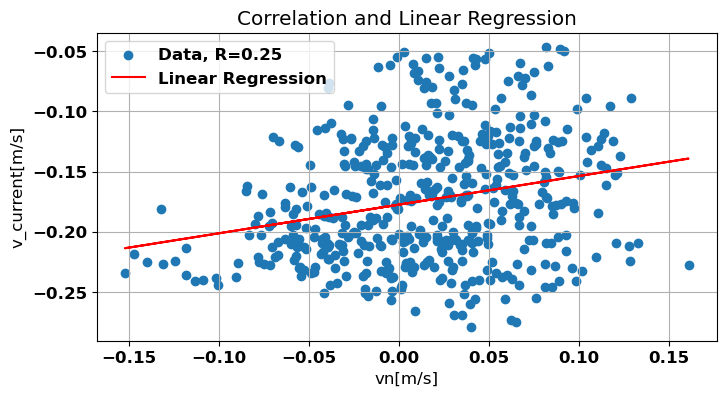

In [144]:
from scipy.stats import pearsonr

# According to the following, we can simply note that the correlation between "ve" and "ugosa_interpolate" is 0.34. 
# This means that there is a general tendency for the values of the variables to increase together, but this relationship is not very strong.
# Calcul de la corrélation spatiale et temporelle Pearson
bouees_courant_v = df_1['vn']
correlation, p_value = pearsonr(dF['v_total'],bouees_courant_v)

print("Corrélation de Pearson:", correlation)
print("Valeur de p (p-value):", p_value)

# Fit linear regression model

slope, intercept, _, _, _ = linregress( bouees_courant_v,dF['v_total'])

# Plot data and linear regression line
plt.figure(figsize=(8, 4))
plt.scatter(bouees_courant_v,dF['v_total'], label=f'Data, R={correlation:.2f}')
plt.plot(bouees_courant_v, slope*bouees_courant_v + intercept, color='red', label='Linear Regression')
plt.xlabel('vn[m/s]')
plt.ylabel('v_current[m/s]')
plt.legend()
plt.title('Correlation and Linear Regression')
plt.grid(True)

# Set font size and font weight for tick labels
plt.rcParams['font.size'] = 12
plt.rcParams['font.weight'] = 'bold'

# save graphe
# plt.savefig("fig11 mode.png")
# Show plot
plt.show()

## Using Time Series

### The use of Kalman filter for smoothing $v_n$ and $v_total$

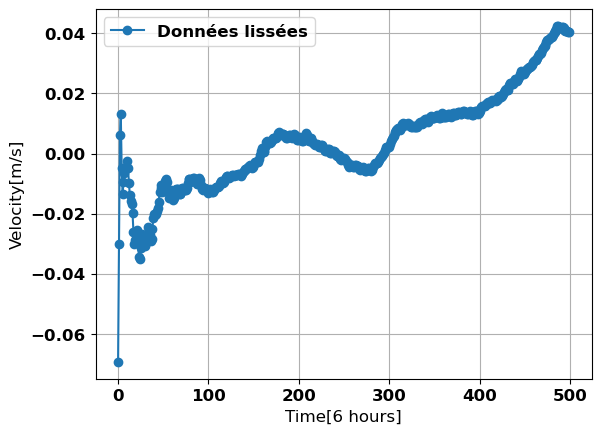

In [145]:
import numpy as np
import matplotlib.pyplot as plt

class KalmanFilter:
    def __init__(self, process_variance, measurement_variance, estimated_measurement_variance):
        self.process_variance = process_variance
        self.measurement_variance = measurement_variance
        self.estimated_measurement_variance = estimated_measurement_variance
        self.posteri_estimate = 0.0
        self.posteri_error_estimate = 1.0

    def update(self, measurement):
        # Prediction update
        priori_estimate = self.posteri_estimate
        priori_error_estimate = self.posteri_error_estimate + self.process_variance

        # Measurement update
        blending_factor = priori_error_estimate / (priori_error_estimate + self.estimated_measurement_variance)
        self.posteri_estimate = priori_estimate + blending_factor * (measurement - priori_estimate)
        self.posteri_error_estimate = (1 - blending_factor) * priori_error_estimate

    def get_latest_estimated_measurement(self):
        return self.posteri_estimate

# Charger la série temporelle
# Supposons que votre série temporelle est dans un array numpy appelé "serie_temporelle"
# Remplacez "serie_temporelle.npy" par le nom de votre fichier contenant la série temporelle
serie_temporelle = bouees_courant_v

# Paramètres du filtre de Kalman
process_variance = 1e-5
measurement_variance = 0.1
estimated_measurement_variance = 0.1

# Initialiser le filtre de Kalman
kf = KalmanFilter(process_variance, measurement_variance, estimated_measurement_variance)

# Lisser la série temporelle en utilisant le filtre de Kalman
filtered_values_3 = []
for measurement in serie_temporelle:
    kf.update(measurement)
    filtered_values_3.append(kf.get_latest_estimated_measurement())

# Afficher les données originales et lissées
#plt.plot(df_1['time'],serie_temporelle, marker='o', linestyle='-', label='Données originales')
plt.plot(filtered_values_3, marker='o', linestyle='-', label='Données lissées')
plt.xlabel('Time[6 hours]')
plt.ylabel('Velocity[m/s]')
plt.grid(True)
plt.legend()
plt.show()

## case of $v_total$

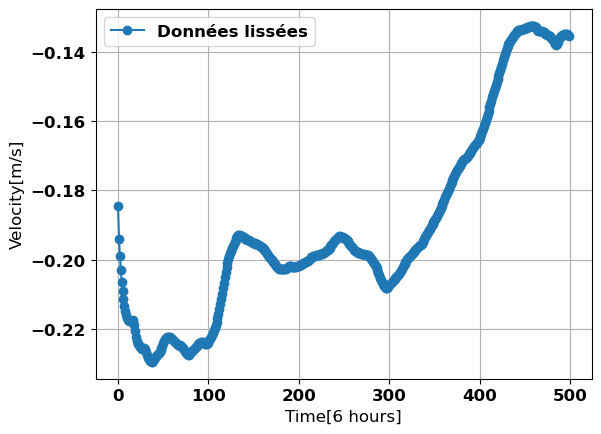

In [146]:
import numpy as np
import matplotlib.pyplot as plt

class KalmanFilter:
    def __init__(self, process_variance, measurement_variance, estimated_measurement_variance):
        self.process_variance = process_variance
        self.measurement_variance = measurement_variance
        self.estimated_measurement_variance = estimated_measurement_variance
        self.posteri_estimate = 0.0
        self.posteri_error_estimate = 1.0

    def update(self, measurement):
        # Prediction update
        priori_estimate = self.posteri_estimate
        priori_error_estimate = self.posteri_error_estimate + self.process_variance

        # Measurement update
        blending_factor = priori_error_estimate / (priori_error_estimate + self.estimated_measurement_variance)
        self.posteri_estimate = priori_estimate + blending_factor * (measurement - priori_estimate)
        self.posteri_error_estimate = (1 - blending_factor) * priori_error_estimate

    def get_latest_estimated_measurement(self):
        return self.posteri_estimate

# Charger la série temporelle
# Supposons que votre série temporelle est dans un array numpy appelé "serie_temporelle"
# Remplacez "serie_temporelle.npy" par le nom de votre fichier contenant la série temporelle
serie_temporelle = dF['v_total']

# Paramètres du filtre de Kalman
process_variance = 1e-5
measurement_variance = 0.1
estimated_measurement_variance = 0.1

# Initialiser le filtre de Kalman
kf = KalmanFilter(process_variance, measurement_variance, estimated_measurement_variance)

# Lisser la série temporelle en utilisant le filtre de Kalman
filtered_values_4 = []
for measurement in serie_temporelle:
    kf.update(measurement)
    filtered_values_4.append(kf.get_latest_estimated_measurement())

# Afficher les données originales et lissées
#plt.plot(df_1['time'],serie_temporelle, marker='o', linestyle='-', label='Données originales')
plt.plot(filtered_values_4, marker='o', linestyle='-', label='Données lissées')
plt.xlabel('Time[6 hours]')
plt.ylabel('Velocity[m/s]')
plt.grid(True)
plt.legend()
plt.show()

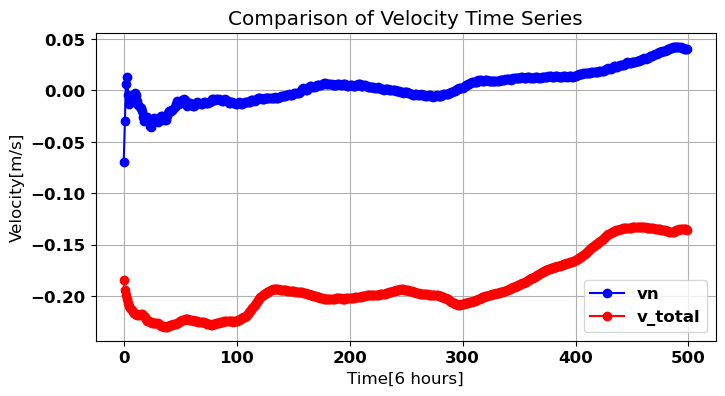

In [126]:
# Plot time series
plt.figure(figsize=(8, 4))
plt.plot(filtered_values_3, color='Blue', marker='o', linestyle='-',label='vn')
plt.plot(filtered_values_4, color='RED', marker='o', linestyle='-', label='v_total')
plt.legend([f'Correlation: {correlation:.2f}'], loc='upper left')

# Add title, axis labels, grid and legend 
plt.title('Comparison of Velocity Time Series')
plt.xlabel('Time[6 hours]')
plt.ylabel('Velocity[m/s]')
plt.grid(True)
plt.legend()

# save graphe
#plt.savefig("fig12 mode.png")
# Show plot
plt.show()

## Conclusion
- We notice that the calculated Ekman current is dominated by the meridional component. 
- By adding the Ekman current to the zonal and meridional geostrophic currents from NOAA satellites, we observe a clear improvement in the satellite current, which tends to approach more and more closely to that of our drifters.
- Other forces such as inertial waves could potentially contribute more to the improvement of satellite currents. This question will be the subject of our next notebook.